# Training a Gaussian Naive Bayes classifier on financial transaction data

## Step 1 -  Importing the data

In [1]:
# Import data from CSV file.
import pandas as pd

transaction_df = pd.read_csv('data.csv', sep=';', index_col=0)

transaction_df.head(5)

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


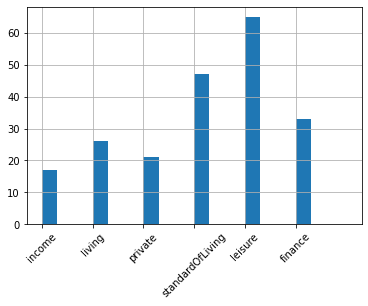

In [2]:
# Visualize label counts.
from matplotlib.pyplot import show

transaction_df["label"].hist(bins=range(7), xrot=45, width=0.3)
show()

## Step 2 - Analyzing the data

## Step 3 - Cleaning the data

In [3]:
#import math

# Condense Buchungstag date to day only as month and year seldomly change.
#transaction_df["Buchungstag"] = transaction_df["Buchungstag"].apply(lambda x: x[0:2])

# Convert Betrag values to float and standardize them.
transaction_df["Betrag"] = transaction_df["Betrag"].apply(lambda x: float(x.replace(',', '.')))
transaction_df["Betrag"] = (transaction_df["Betrag"] - transaction_df["Betrag"].mean())/ transaction_df["Betrag"].std()

# Alternative with rounding to next 10. Do not use as it yields worse results.
#transaction_df['Betrag'] = transaction_df['Betrag'].apply(lambda x: math.ceil(float(x.replace(',', '.'))/10.0)*10)

# For each column except labels: convert to string, remove case and punctuation/special characters.
#for col in transaction_df.columns[:-1]:
 #   transaction_df[col] = transaction_df[col].fillna("keine Angabe")
  #  transaction_df[col] = transaction_df[col].apply(str).str.replace('\W', ' ').str.lower()

#transaction_df.head(20)

In [4]:
# Generate count on individual words in Verwendungszweck. Also removes case, punctuation and special characters. 
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
cvec.fit(transaction_df["Verwendungszweck"])
counts = cvec.transform(transaction_df["Verwendungszweck"]).toarray()

verwendungszweck_df = pd.DataFrame(counts, columns=cvec.get_feature_names())

## Step 4 - Formatting the data

In [5]:
# Omit Valutadatum and Waehrung.
feature_count = pd.concat([pd.get_dummies(transaction_df["Auftragskonto"]),
                           pd.get_dummies(transaction_df["Buchungstag"]),
                           pd.get_dummies(transaction_df["Buchungstext"]),
                           verwendungszweck_df,
                           pd.get_dummies(transaction_df["Beguenstigter/Zahlungspflichtiger"]),
                           pd.get_dummies(transaction_df["Kontonummer"]),
                           pd.get_dummies(transaction_df["BLZ"]),
                           pd.get_dummies(transaction_df["Betrag"])], axis=1)

In [71]:
# Split training and test data.
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(feature_count, transaction_df['label'], test_size=0.2, random_state=5)

## Step 5 - Training and applying the model

In [72]:
# Train model on training data.
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(trainX, trainY)

GaussianNB()

In [73]:
# Generate prediction on test data.
test_result = model.predict(testX)

## Step 6 - Evaluating the model's predictions

In [95]:
# Generate various metrics.
from sklearn import metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
from IPython.display import HTML, display

accuracy  = metrics.accuracy_score(testY, test_result)
hamming   = metrics.hamming_loss(testY,test_result)
precision = metrics.precision_score(testY, test_result, average=None)
recall    = metrics.recall_score(testY, test_result, average=None)
f1        = metrics.f1_score(testY, test_result, average=None)

print("\033[1mAccuracy\033[0m      : {}".format(accuracy))
print("\033[1mHamming Loss\033[0m  : {}".format(hamming))

# Cross validation with random permutation.
crossval = ShuffleSplit(n_splits=10, test_size=0.2, random_state=5)
scores = cross_val_score(model, testX, testY, cv=crossval)
#print(scores)
print("\033[1mCrossVal mean\033[0m : {}".format(scores.mean()))

row_names = ["Precision", "Recall", "F1"]
col_names = list(set(transaction_df["label"]))
col_names.sort()

metrics_df = pd.DataFrame([precision] + [recall] + [f1], index=row_names, columns=names).transpose()
display(HTML(metrics_df.to_html()))

Accuracy      : 0.9761904761904762
Hamming Loss  : 0.023809523809523808
CrossVal mean : 0.8222222222222222


,Precision,Recall,F1
finance,1.000000,1.000000,1.000000
income,1.000000,1.000000,1.000000
leisure,1.000000,0.916667,0.956522
living,0.857143,1.000000,0.923077
private,1.000000,1.000000,1.000000
standardOfLiving,1.000000,1.000000,1.000000


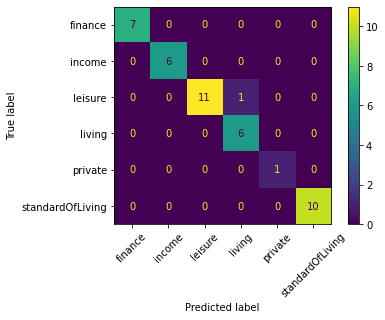

In [75]:
# Visualize result with confusion matrix.
metrics.plot_confusion_matrix(model, testX, testY, xticks_rotation=45)
show()

In [76]:
print("{}% of all predictions were correct.".format(round(accuracy, 5) * 100))

97.619% of all predictions were correct.
